In [ ]:
access_token = ""

In [2]:
idCuda = 3
idTorch = 0

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{str(idCuda)}"

In [4]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, default_data_collator, EarlyStoppingCallback, IntervalStrategy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score # Import all needed metrics
#from torch.utils.data import DataLoader, Dataset

In [5]:
torch.cuda.device_count()

1

In [6]:
torch.cuda.empty_cache()
torch.cuda.set_device(idTorch)

if torch.cuda.is_available():
    GPU = torch.cuda.get_device_name(idTorch)
    print(f"PyTorch available GPU: {GPU}")
else:
    print("GPU not available")

PyTorch available GPU: NVIDIA RTX A5000


In [7]:
device = torch.device(f"cuda:{idTorch}" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


In [8]:
topicos = False
fiveOrTree = False
classes = 3
classCol = 'sentiment'
if fiveOrTree:
    classes = 5
    classCol = 'scoreSA'

In [9]:
test_size = 0.2
locationOriginalDataset = '/home/patrick.araujo/commentsGooglePlay/output/netflix3_balanced_output.csv'
print(f'Usando para o cojunto de teste {100-test_size*100}% e validação {test_size*100}% de:  "{locationOriginalDataset}"')
dataset = pd.read_csv(locationOriginalDataset)

Usando para o cojunto de teste 80.0% e validação 20.0% de:  "/home/patrick.araujo/commentsGooglePlay/output/netflix3_balanced_output.csv"


In [10]:
dataset

,level_0,index,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment,lengthContent,Language,scoreSA
0,1199,NaN,NaN,15765,NaN,NaN,i really use to play netflix but every time yo...,3,NaN,NaN,NaN,NaN,NaN,NaN,1,507,NaN,2
1,2150,2272.0,3119.0,80,Abdull Randhawa,https://play-lh.googleusercontent.com/a/ACg8oc...,This besat AP in movie Netflix bt now download...,1,0.0,NaN,2023-12-12 02:23:18,NaN,NaN,NaN,0,58,en,0
2,1221,NaN,NaN,5790,NaN,NaN,never had a problem with this app. always work...,5,NaN,NaN,NaN,NaN,NaN,NaN,2,471,NaN,4
3,5925,6293.0,3701.0,3452,Sabby Bunny,https://play-lh.googleusercontent.com/a-/ALV-U...,"HDR content is very dark, low brightness issue",2,0.0,8.59.1 build 12 50370,2023-03-16 00:42:39,NaN,NaN,8.59.1 build 12 50370,0,46,en,1
4,1508,NaN,NaN,15780,NaN,NaN,more like then none either find articles that ...,4,NaN,NaN,NaN,NaN,NaN,NaN,2,138,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20557,7860,8318.0,1521.0,9758,Chara 257,https://play-lh.googleusercontent.com/a-/ALV-U...,I love it but 90% of the time i end up with th...,3,1.0,8.86.0 build 6 50506,2023-09-15 17:54:20,NaN,NaN,8.86.0 build 6 50506,1,87,en,2
20558,1291,NaN,NaN,5320,NaN,NaN,bro music video was good for movie including a...,3,NaN,NaN,NaN,NaN,NaN,NaN,1,128,NaN,2
20559,1601,NaN,NaN,17678,NaN,NaN,best ott video on web app nominee,4,NaN,NaN,NaN,NaN,NaN,NaN,2,33,NaN,3
20560,4149,4404.0,1159.0,310,Ian D,https://play-lh.googleusercontent.com/a-/ALV-U...,Will not allow me to cast to TV. Cast logo wil...,2,1.0,8.89.0 build 5 50516,2023-10-09 00:57:06,NaN,NaN,8.89.0 build 5 50516,0,198,en,1


In [11]:
dataset.shape

(20562, 18)

In [12]:
score_counts_balanced = dataset['scoreSA'].value_counts().sort_index()
print(score_counts_balanced)

scoreSA
0    3309
1    3545
2    6854
3    4485
4    2369
Name: count, dtype: int64


In [13]:
sentiments_counts_balanced = dataset['sentiment'].value_counts().sort_index()
print(sentiments_counts_balanced)

sentiment
0    6854
1    6854
2    6854
Name: count, dtype: int64


In [14]:
generated_RO = dataset[dataset['index'].isna()]
df_original = dataset[~dataset['index'].isna()]

score_dfO_counts_balanced = df_original[classCol].value_counts().sort_index()
highest_count = score_dfO_counts_balanced.max()
highest_value = score_dfO_counts_balanced[score_dfO_counts_balanced == highest_count].index[0]

In [15]:
train_data_AllC = None
val_data_AllC = None

df_filtered_scMAX = df_original[df_original[classCol] == highest_value].reset_index(drop=True)
train_dataMAX, val_dataMAX = train_test_split(df_filtered_scMAX, test_size=test_size, random_state=42)

all_dfs_Train = []
all_dfs_Val = []

all_dfs_Train.append(train_dataMAX)
all_dfs_Val.append(val_dataMAX)

for score_value, count in score_dfO_counts_balanced.items():
    if (highest_value != score_value):
        df_filtered_scTemp = df_original[df_original[classCol] == score_value].reset_index(drop=True)
        train_dataTemp, val_dataTemp = train_test_split(df_filtered_scTemp, test_size=len(val_dataMAX), train_size=None, random_state=42)
        remainingGenRO = generated_RO[generated_RO[classCol] == score_value].reset_index(drop=True)
        merged_df = pd.concat([remainingGenRO, train_dataTemp])
        merged_df = merged_df.reset_index(drop=True)
        merged_df = merged_df.sample(frac=1)
        val_dataTemp = val_dataTemp.sample(frac=1)
        all_dfs_Train.append(merged_df)
        all_dfs_Val.append(val_dataTemp)
combined_df_Train = pd.concat(all_dfs_Train, ignore_index=True)
combined_df_Train = combined_df_Train.sample(frac=1)
train_data_AllC = combined_df_Train.reset_index(drop=True)
combined_df_Val = pd.concat(all_dfs_Val, ignore_index=True)
combined_df_Val = combined_df_Val.sample(frac=1)
val_data_AllC = combined_df_Val.reset_index(drop=True)

In [16]:
train_data_AllC

,level_0,index,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment,lengthContent,Language,scoreSA
0,5380,5718.0,2951.0,125,SevIsCrazy! NG (SevenGG),https://play-lh.googleusercontent.com/a-/ALV-U...,Barely works anymore actually. Anytime I watch...,2,7.0,8.67.1 build 11 50414,2023-05-11 12:44:31,NaN,NaN,8.67.1 build 11 50414,0,153,en,1
1,82,NaN,NaN,1463,NaN,NaN,please watch music to be controlled or device ...,3,NaN,NaN,NaN,NaN,NaN,NaN,1,145,NaN,2
2,900,NaN,NaN,3966,NaN,NaN,brightness achieved by working on my s23 。,3,NaN,NaN,NaN,NaN,NaN,NaN,1,42,NaN,2
3,2000,2117.0,2901.0,12948,Nicole Rivett-Carnac,https://play-lh.googleusercontent.com/a-/ALV-U...,Since the last update the app is very laggy an...,1,0.0,8.96.1 build 16 50568,2023-12-15 02:36:40,NaN,NaN,8.96.1 build 16 50568,0,116,en,0
4,4956,5265.0,2312.0,17328,Jedida,https://play-lh.googleusercontent.com/a-/ALV-U...,They are concerned about politically right wit...,2,0.0,8.30.0 build 5 40236,2023-07-06 06:59:34,NaN,NaN,8.30.0 build 5 40236,0,189,en,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16444,1165,NaN,NaN,19002,NaN,NaN,i have no problem living the way it's...,3,NaN,NaN,NaN,NaN,NaN,NaN,1,40,NaN,2
16445,1137,1196.0,1649.0,17659,POONAM UNIYAL,https://play-lh.googleusercontent.com/a/ACg8oc...,This app is very very bad 👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎Boo,1,0.0,NaN,2024-01-01 08:06:25,NaN,NaN,NaN,0,46,en,0
16446,2239,NaN,NaN,5516,NaN,NaN,waiting for 7th time of not you in 19th aug 20...,3,NaN,NaN,NaN,NaN,NaN,NaN,1,150,NaN,2
16447,1245,NaN,NaN,15848,NaN,NaN,"you do a few interesting things we watch, but ...",3,NaN,NaN,NaN,NaN,NaN,NaN,1,214,NaN,2


In [17]:
val_data_AllC

,level_0,index,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment,lengthContent,Language,scoreSA
0,12130,12842.0,4590.0,20535,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Love this app. Taking netflix on the go is awe...,4,0.0,8.49.0 build 16 50315,2023-04-30 15:36:01,NaN,NaN,8.49.0 build 16 50315,2,138,en,3
1,10533,11138.0,1082.0,10259,Holy Meera,https://play-lh.googleusercontent.com/a/ACg8oc...,I need more update about one piece anime pleas...,4,0.0,8.92.0 build 8 50533,2023-11-12 04:14:56,NaN,NaN,8.92.0 build 8 50533,2,51,en,3
2,10738,11354.0,1530.0,14468,Cerys,https://play-lh.googleusercontent.com/a/ACg8oc...,"Always good, with great films to watch and alw...",4,3.0,8.9.1 build 14 40080,2023-10-13 08:10:04,NaN,NaN,8.9.1 build 14 40080,2,196,en,3
3,6511,6908.0,4524.0,18449,Miriam Njeri,https://play-lh.googleusercontent.com/a/ACg8oc...,I like that app soo much when am bored it's he...,2,0.0,8.51.0 build 6 50325,2023-01-07 16:52:22,NaN,NaN,8.51.0 build 6 50325,0,51,en,1
4,10684,11298.0,1416.0,3889,Madhuri Rajesh,https://play-lh.googleusercontent.com/a/ACg8oc...,Frequently unable to open the app,4,0.0,8.91.1 build 10 50529,2023-10-22 08:21:11,NaN,NaN,8.91.1 build 10 50529,2,33,en,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4108,6922,7334.0,89.0,19046,Iker Espina,https://play-lh.googleusercontent.com/a-/ALV-U...,they skipped a lot of episodes in One Piece (f...,3,0.0,NaN,2024-01-17 03:27:41,NaN,NaN,NaN,1,80,en,2
4109,7426,7866.0,854.0,7358,Maria Hernandez,https://play-lh.googleusercontent.com/a/ACg8oc...,Cannot turn down screen brightness on Pixel 8 Pro,3,0.0,NaN,2023-11-07 14:37:55,NaN,NaN,NaN,1,49,en,2
4110,5603,5956.0,3251.0,14696,Lois Carlin,https://play-lh.googleusercontent.com/a-/ALV-U...,Seemed like a phishing exhibition! I got in ti...,2,0.0,NaN,2023-04-19 05:09:30,NaN,NaN,NaN,0,57,en,1
4111,10608,11217.0,1246.0,16495,Zulasyraf Ismail,https://play-lh.googleusercontent.com/a-/ALV-U...,Lame repetitive shows with many filler episodes,4,0.0,8.93.1 build 4 50540,2023-11-01 07:16:12,NaN,NaN,8.93.1 build 4 50540,2,47,en,3


In [18]:
print(val_data_AllC[val_data_AllC['index'].isna()])

Empty DataFrame
Columns: [level_0, index, Unnamed: 0, reviewId, userName, userImage, content, score, thumbsUpCount, reviewCreatedVersion, at, replyContent, repliedAt, appVersion, sentiment, lengthContent, Language, scoreSA]
Index: []


In [19]:
train_data = None
val_data = None

if topicos:
    train_data = train_data_AllC[['content', 'topics', classCol]]
    val_data = val_data_AllC[['content', 'topics', classCol]]
else:
    train_data = train_data_AllC[['content', classCol]]
    val_data = val_data_AllC[['content', classCol]]

In [20]:
# Load the pre-trained BERT model and tokenizer
model_name = "google-t5/t5-small"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5, token=access_token)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google-t5/t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Move model to GPU
model = model.to(device)

In [22]:
print("Training Data")
print(train_data[classCol].value_counts().sort_index())
print("\nValidation Data")
print(val_data[classCol].value_counts().sort_index())

Training Data
sentiment
0    5483
1    5483
2    5483
Name: count, dtype: int64

Validation Data
sentiment
0    1371
1    1371
2    1371
Name: count, dtype: int64


In [23]:
train_data

,content,sentiment
0,Barely works anymore actually. Anytime I watch...,0
1,please watch music to be controlled or device ...,1
2,brightness achieved by working on my s23 。,1
3,Since the last update the app is very laggy an...,0
4,They are concerned about politically right wit...,0
...,...,...
16444,i have no problem living the way it's...,1
16445,This app is very very bad 👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎Boo,0
16446,waiting for 7th time of not you in 19th aug 20...,1
16447,"you do a few interesting things we watch, but ...",1


In [24]:
val_data

,content,sentiment
0,Love this app. Taking netflix on the go is awe...,2
1,I need more update about one piece anime pleas...,2
2,"Always good, with great films to watch and alw...",2
3,I like that app soo much when am bored it's he...,0
4,Frequently unable to open the app,2
...,...,...
4108,they skipped a lot of episodes in One Piece (f...,1
4109,Cannot turn down screen brightness on Pixel 8 Pro,1
4110,Seemed like a phishing exhibition! I got in ti...,0
4111,Lame repetitive shows with many filler episodes,2


In [25]:
max_length = 512

In [26]:
def tokenizerFunctionWithTopics(string, topics):
    # Tokenize using tokenizer function
    string_list = eval(topics)
    tokens = tokenizer.encode_plus(string, topics, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    return tokens

def tokenizerFunction(string):
    # Tokenize without topics
    tokens = tokenizer(string, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    return tokens

# Assuming train_data and val_data are defined somewhere in your code
train_encodings = train_data['content'].apply(tokenizerFunction)
if topicos:
    train_encodings = train_data.apply(lambda x: tokenizerFunctionWithTopics(x['content'], x['topics']), axis=1)
val_encodings = val_data['content'].apply(tokenizerFunction)

In [27]:
train_encodings

0        [input_ids, attention_mask]
1        [input_ids, attention_mask]
2        [input_ids, attention_mask]
3        [input_ids, attention_mask]
4        [input_ids, attention_mask]
                    ...             
16444    [input_ids, attention_mask]
16445    [input_ids, attention_mask]
16446    [input_ids, attention_mask]
16447    [input_ids, attention_mask]
16448    [input_ids, attention_mask]
Name: content, Length: 16449, dtype: object

In [28]:
val_encodings

0       [input_ids, attention_mask]
1       [input_ids, attention_mask]
2       [input_ids, attention_mask]
3       [input_ids, attention_mask]
4       [input_ids, attention_mask]
                   ...             
4108    [input_ids, attention_mask]
4109    [input_ids, attention_mask]
4110    [input_ids, attention_mask]
4111    [input_ids, attention_mask]
4112    [input_ids, attention_mask]
Name: content, Length: 4113, dtype: object

In [29]:
def creatingDataframe(encodings):
  indices = encodings.index.to_numpy()

  df = pd.DataFrame(columns=['input_ids', 'attention_mask'])
  
  # Assuming 'content' is a Series or List containing tuples/lists
  for element in encodings:
    input_ids = element['input_ids'][0].numpy()              # Replace with correct index based on your data structure
    attention_mask = element['attention_mask'][0].numpy()    # Replace with correct index
    df.loc[len(df.index)] = [input_ids, attention_mask]
  df_index = pd.DataFrame(indices, columns=['index'])
  df['index'] = df_index['index']
  return df

# Batch Size

In [30]:
# Define batch size and create data loaders
batch_size = 16  # Adjust as needed

In [31]:
# Create datasets
# Convert labels to tensors
train_dataset = creatingDataframe(train_encodings)
train_labels = train_data[classCol].reset_index(name='label')
train_dataset = pd.merge(train_dataset, train_labels, on='index')

val_dataset = creatingDataframe(val_encodings)
val_labels = val_data[classCol].reset_index(name='label')
val_dataset = pd.merge(val_dataset, val_labels, on='index')

In [32]:
train_dataset = train_dataset.drop('index', axis=1)
val_dataset = val_dataset.drop('index', axis=1)

In [33]:
train_dataset

,input_ids,attention_mask,label
0,"[2659, 4610, 930, 7595, 700, 5, 2372, 715, 27,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1,"[754, 1605, 723, 12, 36, 6478, 42, 1407, 610, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,"[24073, 5153, 57, 464, 30, 82, 3, 7, 2773, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",1
3,"[1541, 8, 336, 2270, 8, 1120, 19, 182, 50, 955...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,"[328, 33, 4376, 81, 22937, 269, 28, 70, 939, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
...,...,...,...
16444,"[3, 23, 43, 150, 682, 840, 8, 194, 34, 31, 7, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",1
16445,"[100, 1120, 19, 182, 182, 1282, 3, 2, 279, 32,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",0
16446,"[2794, 21, 489, 189, 97, 13, 59, 25, 16, 957, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
16447,"[25, 103, 3, 9, 360, 1477, 378, 62, 1605, 6, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


In [34]:
val_dataset

,input_ids,attention_mask,label
0,"[2129, 48, 1120, 5, 3, 12297, 3134, 89, 17591,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
1,"[27, 174, 72, 2270, 81, 80, 1466, 21705, 754, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",2
2,"[8904, 207, 6, 28, 248, 4852, 12, 1605, 11, 37...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
3,"[27, 114, 24, 1120, 78, 32, 231, 116, 183, 196...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,"[3, 31349, 3, 6319, 12, 539, 8, 1120, 1, 0, 0,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...",2
...,...,...,...
4108,"[79, 26205, 26, 3, 9, 418, 13, 13562, 16, 555,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4109,"[1072, 2264, 919, 323, 1641, 24073, 30, 20005,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",1
4110,"[1610, 2726, 114, 3, 9, 3, 11692, 9525, 4473, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4111,"[15763, 15, 24869, 1267, 28, 186, 14, 49, 1356...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...",2


In [35]:
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)

In [36]:
path = ''

In [37]:
# Define training arguments with early stopping
training_args = TrainingArguments(
    # Positional arguments:
    output_dir= path+"./t5-small_sentiment_model",
    logging_dir= path+"./logs_t5s",
    #device=device,

    # Keyword arguments:
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    #eval_steps=250,                         # Adjust as needed
    save_total_limit=2,                     # Adjust as needed. Only last 2 models are saved. Older ones are deleted.
    num_train_epochs=5,                     # Adjust as needed
    save_steps=500,                         # Adjust as needed
    metric_for_best_model="eval_loss",      # Use validation loss for early stopping
    learning_rate= 7e-05,
    warmup_steps=500,
    weight_decay=0.001,
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [38]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, mean_absolute_error

def compute_metrics(eval_preds):

    logits = eval_preds.predictions
    labels = eval_preds.label_ids
    # Convert logits to predicted labels
    
    predicted_labels = np.argmax(logits[0], axis=1)
    
    
    metrics = {}
    # Calculate accuracy
    accuracy = accuracy_score(labels, predicted_labels)
    # balanced_accuracy = balanced_accuracy_score(labels, predicted_labels)
    metrics['accuracy'] = accuracy
    # metrics['balanced_accuracy'] = balanced_accuracy

    # Calculate accuracy for each class
    class_accuracy = {}
    for i in range(len(np.unique(labels))):
        class_indices = np.where(labels == i)[0]
        class_accuracy[f'class_{i}'] = accuracy_score(labels[class_indices], predicted_labels[class_indices])
    
    # Calculate precision, recall, F1 score, and support for each class
    precision, recall, f1, support = precision_recall_fscore_support(labels, predicted_labels)    
    
    # Create a dictionary to store metrics for each class
    class_metrics = {}
    # Include class-wise accuracy in the metrics
    i = 0
    for class_name, acc in class_accuracy.items():
        class_metrics[f'class_{i}'] = {
            'accuracy': acc,
            'precision': precision[i],
            'recall': recall[i],
            'f1': f1[i],
            'support': support[i]
        }
        i = i+1

    precision_ALL = precision_score(labels, predicted_labels, average='macro')
    recall_ALL = recall_score(labels, predicted_labels, average='macro')
    f1_ALL = f1_score(labels, predicted_labels, average='macro')
    mae_ALL = mean_absolute_error(labels, predicted_labels)

    metrics['precision'] = precision_ALL
    metrics['recall'] = recall_ALL
    metrics['f1'] = f1_ALL
    metrics['mae'] = mae_ALL
    
    # Print and return the metrics
    for class_name, c_metrics in class_metrics.items():
        metrics[f'{class_name}_accuracy'] = c_metrics["accuracy"]
        metrics[f'{class_name}_precision'] = c_metrics["precision"]
        metrics[f'{class_name}_recall'] = c_metrics["recall"]
        metrics[f'{class_name}_f1'] = c_metrics["f1"]
        metrics[f'{class_name}_support'] = c_metrics["support"]

    return metrics

In [39]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [40]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Mae,Class 0 Accuracy,Class 0 Precision,Class 0 Recall,Class 0 F1,Class 0 Support,Class 1 Accuracy,Class 1 Precision,Class 1 Recall,Class 1 F1,Class 1 Support,Class 2 Accuracy,Class 2 Precision,Class 2 Recall,Class 2 F1,Class 2 Support
1,0.804700,1.117157,0.519815,0.522955,0.519815,0.443795,0.621687,0.908826,0.450470,0.908826,0.602369,1371,0.046681,0.426667,0.046681,0.084155,1371,0.603939,0.691729,0.603939,0.644860,1371
2,0.732200,1.042084,0.548748,0.541880,0.548748,0.481373,0.566253,0.875274,0.491199,0.875274,0.629261,1371,0.083151,0.475000,0.083151,0.141527,1371,0.687819,0.659441,0.687819,0.673331,1371
3,0.700300,1.058568,0.546560,0.538373,0.546560,0.475500,0.570630,0.874544,0.489388,0.874544,0.627584,1371,0.072939,0.471698,0.072939,0.126342,1371,0.692195,0.654032,0.692195,0.672573,1371
4,0.665200,1.033582,0.551909,0.552200,0.551909,0.505240,0.557014,0.867980,0.491127,0.867980,0.627306,1371,0.143691,0.471292,0.143691,0.220235,1371,0.644055,0.694182,0.644055,0.668180,1371
5,0.646300,1.046768,0.553124,0.547636,0.553124,0.493754,0.557014,0.868709,0.493781,0.868709,0.629659,1371,0.105762,0.476974,0.105762,0.173134,1371,0.684902,0.672155,0.684902,0.678468,1371


Could not locate the best model at ./t5-small_sentiment_model/checkpoint-4116/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=5145, training_loss=0.7456204279982082, metrics={'train_runtime': 2028.3304, 'train_samples_per_second': 40.548, 'train_steps_per_second': 2.537, 'total_flos': 1.119819630878208e+16, 'train_loss': 0.7456204279982082, 'epoch': 5.0})

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use the trainer to predict labels on the validation dataset
predictions = trainer.predict(val_dataset)
logits = predictions[0]
predictions, labels = logits
predicted_labels = np.argmax(predictions, axis=1)
# Extract the true labels from the validation dataset
true_labels = val_dataset['label']

# Generate the confusion matrix
unique_labels = np.sort(dataset[classCol].unique())

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)

print("Confusion Matrix:")
print(conf_matrix)
# Mapping from number to string

mapping = {0: 'Negative (0)', 1: 'Neutral (1)', 2: 'Positive (2)'}
if fiveOrTree:
    mapping = {0: 'Very Negative (1)', 1: 'Negative (2)', 2: 'Neutral (3)', 3: 'Positive (4)', 4: 'Very Positive (5)'}

# Applying mapping
classes = [mapping[value] for value in unique_labels]

Confusion Matrix:
[[1191   84   96]
 [ 864  145  362]
 [ 357   75  939]]


In [42]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17,17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=2.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")
    plt.savefig(f'{filename}.png',  bbox_inches='tight')
    plt.savefig(f'{filename}.svg',  bbox_inches='tight')

/tmp/ipykernel_3238726/703857389.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)


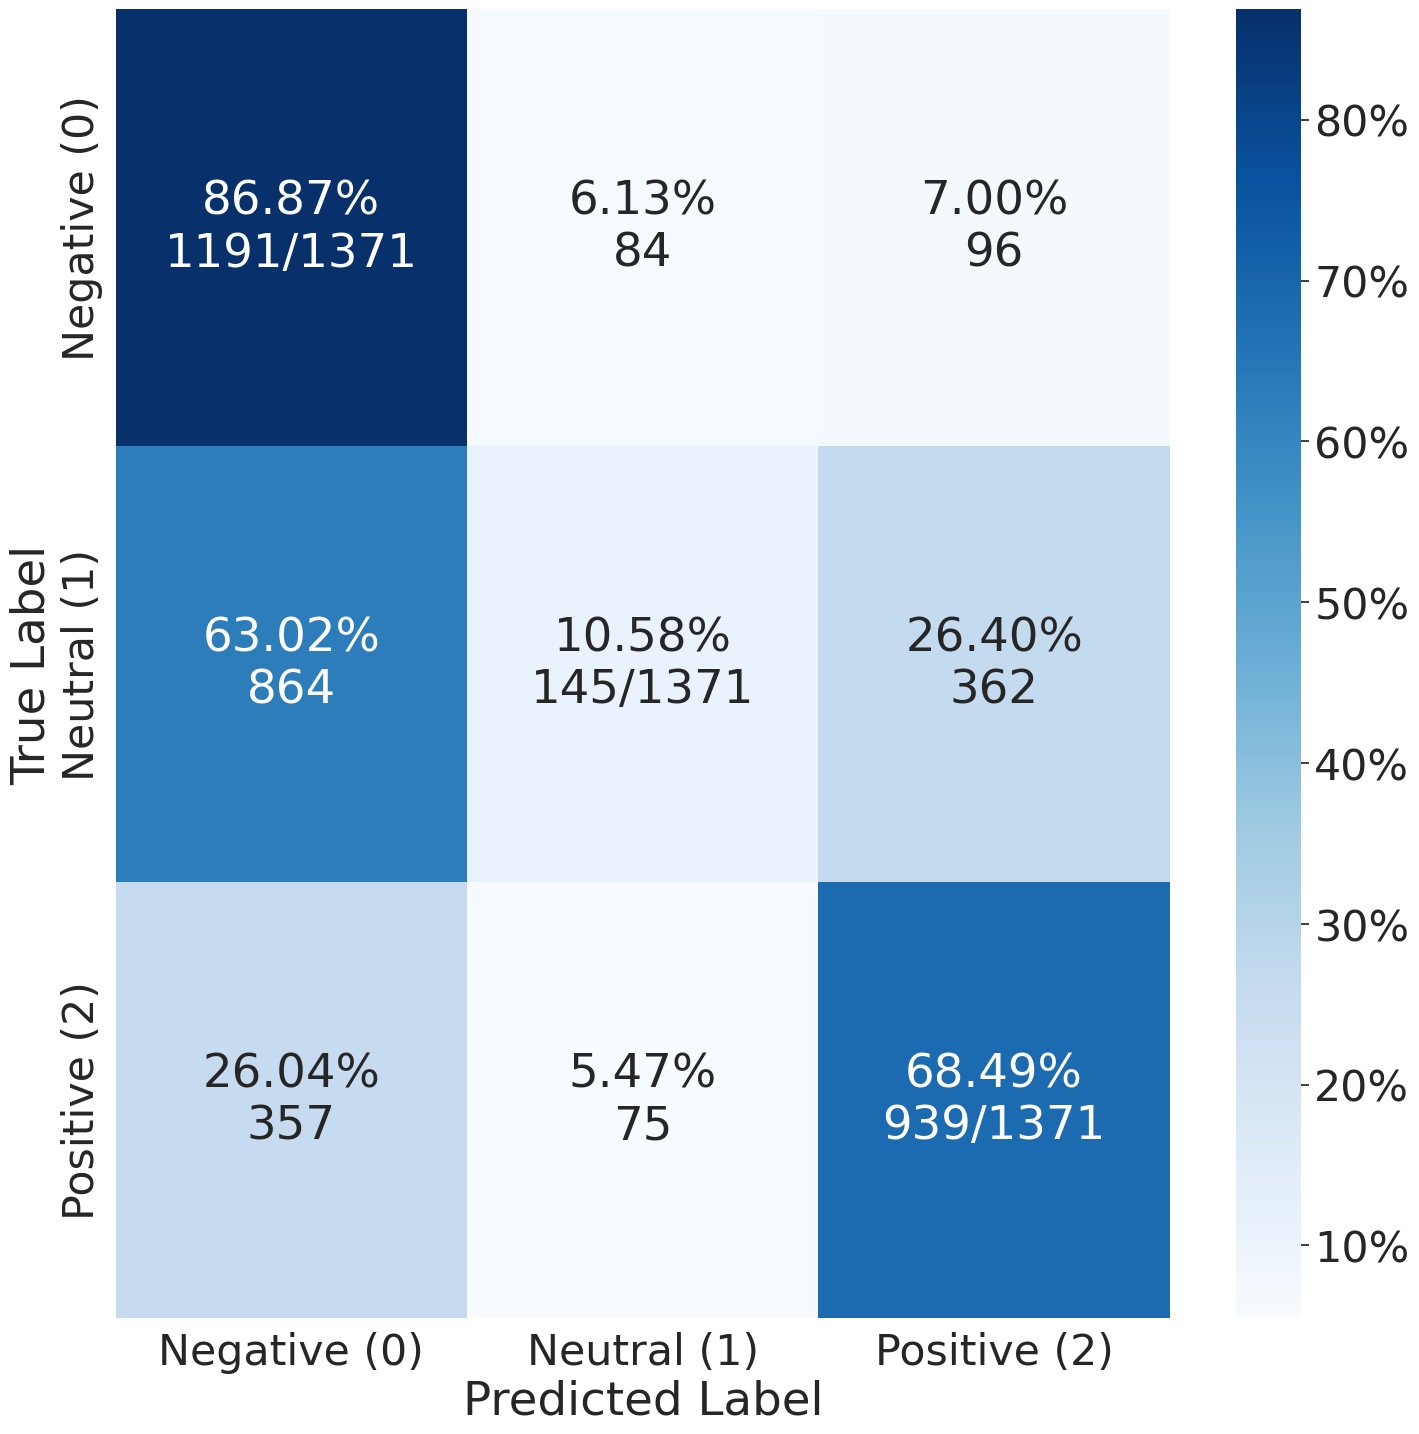

In [43]:
cm_analysis(true_labels, predicted_labels, 'confusion_matrix_t5', unique_labels, classes)

In [44]:
# Evaluate the model
results = trainer.evaluate()

In [45]:
results

{'eval_loss': 1.046768069267273,
 'eval_accuracy': 0.5531242402139558,
 'eval_precision': 0.5476364652581321,
 'eval_recall': 0.5531242402139558,
 'eval_f1': 0.4937538457479053,
 'eval_mae': 0.5570143447605155,
 'eval_class_0_accuracy': 0.8687089715536105,
 'eval_class_0_precision': 0.4937810945273632,
 'eval_class_0_recall': 0.8687089715536105,
 'eval_class_0_f1': 0.6296590007930214,
 'eval_class_0_support': 1371,
 'eval_class_1_accuracy': 0.10576221735959154,
 'eval_class_1_precision': 0.4769736842105263,
 'eval_class_1_recall': 0.10576221735959154,
 'eval_class_1_f1': 0.17313432835820897,
 'eval_class_1_support': 1371,
 'eval_class_2_accuracy': 0.6849015317286652,
 'eval_class_2_precision': 0.6721546170365068,
 'eval_class_2_recall': 0.6849015317286652,
 'eval_class_2_f1': 0.6784682080924855,
 'eval_class_2_support': 1371,
 'eval_runtime': 36.8079,
 'eval_samples_per_second': 111.742,
 'eval_steps_per_second': 7.009,
 'epoch': 5.0}

In [46]:
output_file_path = './t5-small_sentiment_model'
destination = path+output_file_path

# Save the model
model.save_pretrained(destination)

In [47]:
topics_counts_balanced = dataset['topics'].value_counts().sort_index()
print(len(topics_counts_balanced))

KeyError: 'topics'